# Model Training & Evaluation
This notebook trains an LSTM on the preprocessed sequences and evaluates it.

**Prerequisites:** `model/X_train.npy`, `model/y_train.npy`, `model/X_val.npy`, `model/y_val.npy`, `model/X_test.npy`, `model/y_test.npy` and `model/scaler.joblib` should exist.

In [1]:

import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam
import joblib, os

os.makedirs('model', exist_ok=True)

# Load arrays (ensure you've run feature engineering cell that saved these)
X_train = np.load('model/X_train.npy')
y_train = np.load('model/y_train.npy')
X_val   = np.load('model/X_val.npy')
y_val   = np.load('model/y_val.npy')
X_test  = np.load('model/X_test.npy')
y_test  = np.load('model/y_test.npy')

print('Shapes:', X_train.shape, y_train.shape, X_val.shape, y_val.shape, X_test.shape, y_test.shape)
n_timesteps = X_train.shape[1]
n_features  = X_train.shape[2]


Shapes: (4173, 12, 17) (4173,) (867, 12, 17) (867,) (864, 12, 17) (864,)


In [2]:

# Build LSTM model
model = Sequential([
    LSTM(64, input_shape=(n_timesteps, n_features), return_sequences=False),
    Dropout(0.2),
    Dense(32, activation='relu'),
    Dense(1)
])
model.compile(optimizer=Adam(1e-3), loss='mse', metrics=['mae'])
model.summary()


C:\Users\Asus\anaconda3\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                          │ (None, 64)                  │          20,992 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 23,105 (90.25 KB)

 Trainable params: 23,105 (90.25 KB)

 Non-trainable params: 0 (0.00 B)

In [3]:

# Train (small default epochs to be quick; increase for final training)
history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=10, batch_size=64, verbose=1)
model.save('model/lstm_model.h5')
print('Saved model to model/lstm_model.h5')


Epoch 1/10
66/66 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 392.0011 - mae: 15.5217 - val_loss: 128.7609 - val_mae: 8.0065
Epoch 2/10
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 106.1027 - mae: 7.2285 - val_loss: 49.6245 - val_mae: 4.5908
Epoch 3/10
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 47.6143 - mae: 4.6312 - val_loss: 40.5261 - val_mae: 4.1336
Epoch 4/10
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 43.1732 - mae: 4.3736 - val_loss: 37.4202 - val_mae: 4.0500
Epoch 5/10
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 37.6439 - mae: 4.1150 - val_loss: 33.5785 - val_mae: 3.8968
Epoch 6/10
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 36.6300 - mae: 4.1567 - val_loss: 33.9312 - val_mae: 3.8938
Epoch 7/10
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 35.9040 - mae: 4.0692 - val_loss: 31.5455 - val_mae: 3.8384
Epoch 8/10
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 35.7895 - mae: 4.1217 - val_loss: 30.6314 - val_mae: 3.7967
Epoch 9/10
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step -

Saved model to model/lstm_model.h5


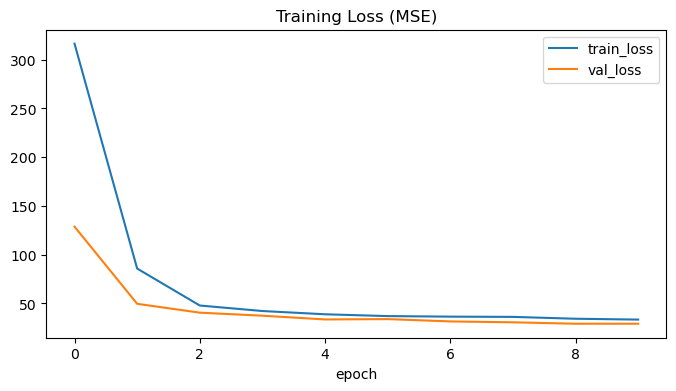

In [4]:

# Plot training curves
plt.figure(figsize=(8,4))
plt.plot(history.history['loss'], label='train_loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.legend(); plt.title('Training Loss (MSE)'); plt.xlabel('epoch'); plt.show()


In [5]:

# Evaluate on test set
y_pred = model.predict(X_test).flatten()
mae = mean_absolute_error(y_test, y_pred)
rmse = mean_squared_error(y_test, y_pred, squared=False)
r2 = r2_score(y_test, y_pred)
print(f'MAE: {mae:.4f}, RMSE: {rmse:.4f}, R2: {r2:.4f}')


27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
MAE: 3.7736, RMSE: 5.4287, R2: 0.8174


C:\Users\Asus\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


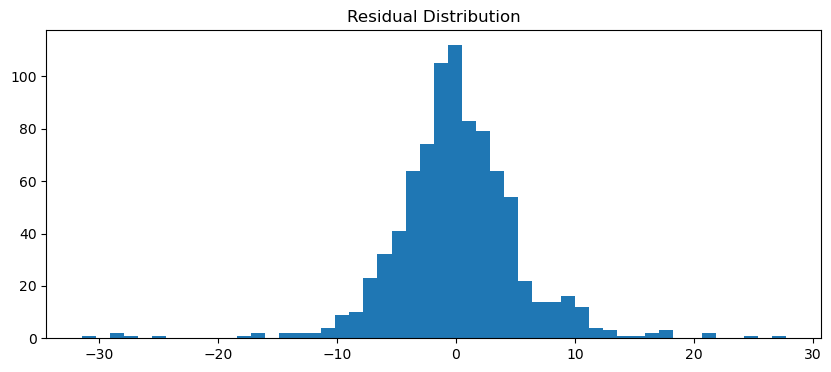

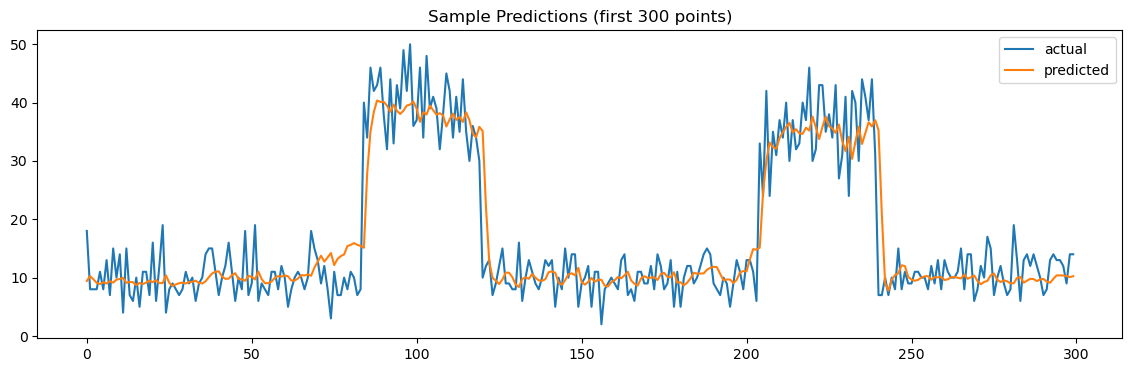

In [6]:

# Residuals and sample predictions
residuals = y_test - y_pred
plt.figure(figsize=(10,4))
plt.hist(residuals, bins=50)
plt.title('Residual Distribution'); plt.show()

plt.figure(figsize=(14,4))
plt.plot(y_test[:300], label='actual')
plt.plot(y_pred[:300], label='predicted')
plt.legend(); plt.title('Sample Predictions (first 300 points)'); plt.show()
